In [7]:
#決策樹介紹
   #feature (特徵欄位)  判斷的資訊 (train.tsv及test.tsv)
   #label (標籤欄位)    預測的目標 (train.tsv)
   #maxBind   每一個節點的最大分支樹
   #maxDepth  決策樹的最大深度
   #Impurity  分裂節點時的方法
#架構流程：
#https://2.bp.blogspot.com/-CyhOxo3HlHo/Vv4HzQO9kCI/AAAAAAAAGMs/Woc3WMgAAnokFlvHitxsIiGv8kooRgksw/s1600/p12.jpg

# 1. 資料準備

In [8]:
sc.master
rawDataWithHeader = sc.textFile("train.tsv")
rawDataWithHeader.take(2)

['"url"\t"urlid"\t"boilerplate"\t"alchemy_category"\t"alchemy_category_score"\t"avglinksize"\t"commonlinkratio_1"\t"commonlinkratio_2"\t"commonlinkratio_3"\t"commonlinkratio_4"\t"compression_ratio"\t"embed_ratio"\t"framebased"\t"frameTagRatio"\t"hasDomainLink"\t"html_ratio"\t"image_ratio"\t"is_news"\t"lengthyLinkDomain"\t"linkwordscore"\t"news_front_page"\t"non_markup_alphanum_characters"\t"numberOfLinks"\t"numwords_in_url"\t"parametrizedLinkRatio"\t"spelling_errors_ratio"\t"label"',
 '"http://www.bloomberg.com/news/2010-12-23/ibm-predicts-holographic-calls-air-breathing-batteries-by-2015.html"\t"4042"\t"{""title"":""IBM Sees Holographic Calls Air Breathing Batteries ibm sees holographic calls, air-breathing batteries"",""body"":""A sign stands outside the International Business Machines Corp IBM Almaden Research Center campus in San Jose California Photographer Tony Avelar Bloomberg Buildings stand at the International Business Machines Corp IBM Almaden Research Center campus in the S

In [9]:
#開始整理資料
header = rawDataWithHeader.first() 
rawData = rawDataWithHeader.filter(lambda x:x !=header)    #將非header給過濾出
rData=rawData.map(lambda x: x.replace("\"", ""))    
lines = rData.map(lambda x: x.split("\t"))
print("共計：" + str(lines.count()) + "筆")

共計：7395筆


In [10]:
lines.first()[3:]

['business',
 '0.789131',
 '2.055555556',
 '0.676470588',
 '0.205882353',
 '0.047058824',
 '0.023529412',
 '0.443783175',
 '0',
 '0',
 '0.09077381',
 '0',
 '0.245831182',
 '0.003883495',
 '1',
 '1',
 '24',
 '0',
 '5424',
 '170',
 '8',
 '0.152941176',
 '0.079129575',
 '0']

In [11]:
#categoriesMap =lines.map(lambda fields: fields[3]).distinct().collect()
#zipWithIndex()由0加到1
categoriesMap =lines.map(lambda fields: fields[3]).distinct().zipWithIndex().collectAsMap()

In [12]:
categoriesMap

{'?': 2,
 'arts_entertainment': 0,
 'business': 6,
 'computer_internet': 1,
 'culture_politics': 10,
 'gaming': 7,
 'health': 13,
 'law_crime': 8,
 'recreation': 12,
 'religion': 4,
 'science_technology': 11,
 'sports': 9,
 'unknown': 5,
 'weather': 3}

In [13]:
len(categoriesMap)

14

In [14]:
import numpy as np
def extract_features(field,categoriesMap,featureEnd):
    #擷取分類特徵欄位
    categoryIdx = categoriesMap[field[3]] 
    categoryFeatures = np.zeros(len(categoriesMap))
    categoryFeatures[categoryIdx] = 1
    #擷取數值欄位
    numericalFeatures=[convert_float(field)  for  field in field[4: featureEnd]]    
    #回傳「分類特徵欄位」+「數字特徵欄位」
    return  np.concatenate(( categoryFeatures, numericalFeatures))

def convert_float(x):
    return (0 if x=="?" else float(x))

In [15]:
def extract_label(field):    #擷取最後一個欄位的標籤
    label=(field[-1])
    return float(label)

In [16]:
#建一個labelRDD
labelRDD = lines.map( lambda r: extract_label(r))
print(labelRDD.take(1))

[0.0]


In [17]:
from pyspark.mllib.regression import LabeledPoint
labelpointRDD = lines.map( lambda r: 
     LabeledPoint(
                extract_label(r),
                extract_features(r,categoriesMap,len(r) - 1)))

In [18]:
print(lines.first()[3:])

['business', '0.789131', '2.055555556', '0.676470588', '0.205882353', '0.047058824', '0.023529412', '0.443783175', '0', '0', '0.09077381', '0', '0.245831182', '0.003883495', '1', '1', '24', '0', '5424', '170', '8', '0.152941176', '0.079129575', '0']


In [19]:
labelpointRDD.take(1) #講上一行的結果的最後一欄位(label為0或1)移至第1順位

[LabeledPoint(0.0, [0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.789131,2.055555556,0.676470588,0.205882353,0.047058824,0.023529412,0.443783175,0.0,0.0,0.09077381,0.0,0.245831182,0.003883495,1.0,1.0,24.0,0.0,5424.0,170.0,8.0,0.152941176,0.079129575])]

In [20]:
# 將DATA分成trainData, validationData, testDATA
(trainData, validationData, testData) = labelpointRDD.randomSplit([8, 1, 1])
print("將資料分trainData:" + str(trainData.count()) +   
          "   validationData:" + str(validationData.count()) + 
          "   testData:" + str(testData.count()))

將資料分trainData:5945   validationData:688   testData:762


In [21]:
### 將上述觀念全部統整 ###
def PrepareData(sc): 
    #----------------------1.匯入並轉換資料-------------
#    global Path    
#    if sc.master[0:5]=="local" :
#       Path="file:/home/hduser/pythonsparkexample/PythonProject/"
#    else:   
#       Path="hdfs://master:9000/user/hduser/"

    print("開始匯入資料...")
    rawDataWithHeader = sc.textFile("train.tsv")
    header = rawDataWithHeader.first() 
    rawData = rawDataWithHeader.filter(lambda x:x !=header)    
    rData=rawData.map(lambda x: x.replace("\"", ""))    
    lines = rData.map(lambda x: x.split("\t"))
    print("共計：" + str(lines.count()) + "筆")
    #----------2.建立訓練評估所需資料 RDD[LabeledPoint]-------    
    categoriesMap = lines.map(lambda fields: fields[3]).\
                                   distinct().zipWithIndex().collectAsMap()
    labelpointRDD = lines.map( lambda r:
               LabeledPoint(
                      extract_label(r), 
                      extract_features(r,categoriesMap,-1)))
    
    labelpointRDDFeaturesInfo = lines.map( lambda r:LabeledPoint(
                 extract_label(r), 
                 extract_features_FeaturesInfo(r,categoriesMap,len(r) - 1)))
        
    #-----------3.以隨機方式將資料分為3部份並且回傳-------------
    (trainData, validationData, testData) = labelpointRDD.randomSplit([8, 1, 1])
    print("將資料分trainData:" + str(trainData.count()) + 
              "   validationData:" + str(validationData.count()) +
              "   testData:" + str(testData.count()))
    return (trainData, validationData, testData, categoriesMap) #回傳資料

In [22]:
(trainData, validationData, testData, categoriesMap) =PrepareData(sc) 

開始匯入資料...
共計：7395筆
將資料分trainData:5875   validationData:748   testData:772


In [23]:
trainData.persist()
validationData.persist()
testData.persist()

PythonRDD[44] at RDD at PythonRDD.scala:48

# 2. 訓練模型

In [24]:
from pyspark.mllib.tree import DecisionTree
model=DecisionTree.trainClassifier( \
        trainData, numClasses=2, categoricalFeaturesInfo={}, \
        impurity="entropy", maxDepth=5, maxBins=5)    #可調整每一個節點的3大參數!!!

In [25]:
model

DecisionTreeModel classifier of depth 5 with 59 nodes

In [26]:
print(model.toDebugString())

DecisionTreeModel classifier of depth 5 with 59 nodes
  If (feature 31 <= 1247.0)
   If (feature 13 <= 0.0)
    If (feature 23 <= 0.038238702)
     If (feature 12 <= 0.0)
      If (feature 6 <= 0.0)
       Predict: 0.0
      Else (feature 6 > 0.0)
       Predict: 1.0
     Else (feature 12 > 0.0)
      If (feature 15 <= 1.915789474)
       Predict: 0.0
      Else (feature 15 > 1.915789474)
       Predict: 1.0
    Else (feature 23 > 0.038238702)
     If (feature 15 <= 1.915789474)
      If (feature 0 <= 0.0)
       Predict: 0.0
      Else (feature 0 > 0.0)
       Predict: 0.0
     Else (feature 15 > 1.915789474)
      If (feature 26 <= 0.018858308)
       Predict: 0.0
      Else (feature 26 > 0.018858308)
       Predict: 0.0
   Else (feature 13 > 0.0)
    If (feature 20 <= 0.623818526)
     If (feature 20 <= 0.433077345)
      If (feature 15 <= 1.915789474)
       Predict: 1.0
      Else (feature 15 > 1.915789474)
       Predict: 0.0
     Else (feature 20 > 0.433077345)
      Predict: 1.

# 3. 使用模型進行預測

In [50]:
import pyprind

def PredictData(sc,model,categoriesMap): 
    print("開始匯入資料...")
    rawDataWithHeader = sc.textFile("test.tsv")
    header = rawDataWithHeader.first() 
    rawData = rawDataWithHeader.filter(lambda x:x !=header)    
    rData=rawData.map(lambda x: x.replace("\"", ""))    
    lines = rData.map(lambda x: x.split("\t"))
    print("共計：" + str(lines.count()) + "筆")
    dataRDD = lines.map(lambda r:  ( r[0]  ,
                            extract_features(r,categoriesMap,len(r) )))
    DescDict = {
           0: "暫時性網頁(ephemeral)",
           1: "長青網頁(evergreen)"
     }
    pbar = pyprind.ProgBar(10)
    for data in dataRDD.take(10):
        predictResult = model.predict(data[1])
        pbar.update()  
        print (" 網址：  " +str(data[0])+"\n" + "==>預測:"+ str(predictResult)+ " 說明:"+DescDict[predictResult] +"\n")
        

In [51]:
print("==========預測資料===============")
PredictData(sc, model, categoriesMap)

0%      100%
[          ]

==========預測資料===============
開始匯入資料...
共計：3171筆


[##########] | ETA: 00:00:00

 網址：  http://www.lynnskitchenadventures.com/2009/04/homemade-enchilada-sauce.html
==>預測:1.0 說明:長青網頁(evergreen)

 網址：  http://lolpics.se/18552-stun-grenade-ar
==>預測:0.0 說明:暫時性網頁(ephemeral)

 網址：  http://www.xcelerationfitness.com/treadmills.html
==>預測:0.0 說明:暫時性網頁(ephemeral)

 網址：  http://www.bloomberg.com/news/2012-02-06/syria-s-assad-deploys-tactics-of-father-to-crush-revolt-threatening-reign.html
==>預測:0.0 說明:暫時性網頁(ephemeral)

 網址：  http://www.wired.com/gadgetlab/2011/12/stem-turns-lemons-and-limes-into-juicy-atomizers/
==>預測:0.0 說明:暫時性網頁(ephemeral)

 網址：  http://www.latimes.com/health/boostershots/la-heb-fat-tax-denmark-20111013,0,2603132.story
==>預測:0.0 說明:暫時性網頁(ephemeral)

 網址：  http://www.howlifeworks.com/a/a?AG_ID=1186&cid=7340ci
==>預測:1.0 說明:長青網頁(evergreen)

 網址：  http://romancingthestoveblog.wordpress.com/2010/01/13/sweet-potato-ravioli-with-lemon-sage-brown-butter-sauce/
==>預測:1.0 說明:長青網頁(evergreen)

 網址：  http://www.funniez.net/Funny-Pictures/turn-men-down.html
==>預測:0.0 說明:


Total time elapsed: 00:00:00


# 4. 評估模型的準確率

AUC
                    |acture
                    |positves      |negatives
____________________|______________|__________
predict |positives  |TP            |FP
        |negatives  |FN            |TN

TPR：所有實際為positives的樣本中，被正確判斷出的比率。
FPR：所有實際為negitives的樣本中，被誤判positives的比率。
TPR= TP/(TP+FN)
FPR= FP/(FP+TN)

AUC 就是用TPR、FRP 畫出的 ROC 曲線下的面積=>斜線越靠近正x軸就越好。

In [29]:
#列出前15筆的預測結果
score = model.predict(validationData.map(lambda p: p.features))
scoreAndLabels=score.zip(validationData.map(lambda p: p.label))
scoreAndLabels.take(15)

[(1.0, 0.0),
 (0.0, 0.0),
 (0.0, 1.0),
 (0.0, 0.0),
 (0.0, 1.0),
 (1.0, 1.0),
 (1.0, 1.0),
 (1.0, 1.0),
 (0.0, 1.0),
 (0.0, 0.0),
 (1.0, 1.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 1.0),
 (1.0, 1.0)]

In [30]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics
metrics = BinaryClassificationMetrics(scoreAndLabels)
print ("AUC="+str(metrics.areaUnderROC))

AUC=0.6654040404040406


In [31]:
def evaluateModel(model, validationData):
    score = model.predict(validationData.map(lambda p: p.features))
    scoreAndLabels=score.zip(validationData.map(lambda p: p.label))
    metrics = BinaryClassificationMetrics(scoreAndLabels)
    AUC=metrics.areaUnderROC
    return(AUC)

In [32]:
AUC=evaluateModel(model, validationData)
print ("AUC="+str(AUC))

AUC=0.6654040404040406


In [52]:
from time import time
def trainEvaluateModel(trainData,validationData,
                                        impurityParm, maxDepthParm, maxBinsParm):
    startTime = time()
    model = DecisionTree.trainClassifier(trainData,
                numClasses=2, categoricalFeaturesInfo={}, impurity=impurityParm,
                maxDepth=maxDepthParm, maxBins=maxBinsParm)
    AUC = evaluateModel(model, validationData)
    duration = time() - startTime
    print ("訓練評估：使用參數" + \
                " impurity="+str(impurityParm) +\
                " maxDepth="+str(maxDepthParm) + \
                " maxBins="+str(maxBinsParm) +"\n" +\
                 " ==>所需時間="+str(duration) + \
                 " 結果AUC = " + str(AUC)) 
    return (AUC,duration, impurityParm, maxDepthParm, maxBinsParm,model)

In [53]:
(AUC,duration, impurityParm, maxDepthParm, maxBinsParm,model)=  \
       trainEvaluateModel(trainData, validationData, "entropy", 5, 5)

訓練評估：使用參數 impurity=entropy maxDepth=5 maxBins=5
 ==>所需時間=1.8657219409942627 結果AUC = 0.6654040404040406


In [54]:
#調節validationData看結果後...再測試比較
(AUC,duration, impurityParm, maxDepthParm, maxBinsParm,model)=  \
       trainEvaluateModel(trainData, testData, "entropy", 5, 5)

訓練評估：使用參數 impurity=entropy maxDepth=5 maxBins=5
 ==>所需時間=1.8704190254211426 結果AUC = 0.6362263391059203


In [66]:
5. 模型的訓練參數如何影響準確率?

SyntaxError: invalid syntax (<ipython-input-66-7e856d8a3433>, line 1)

In [55]:
impurityList=["gini", "entropy"]
maxDepthList  =[10]
maxBinsList=[10]

metrics = [trainEvaluateModel(trainData, validationData,  
                              impurity,maxDepth,  maxBins  ) 
                 for impurity in impurityList 
                 for maxDepth in maxDepthList  
                 for maxBins in maxBinsList ]

訓練評估：使用參數 impurity=gini maxDepth=10 maxBins=10
 ==>所需時間=1.9172449111938477 結果AUC = 0.6257891414141414
訓練評估：使用參數 impurity=entropy maxDepth=10 maxBins=10
 ==>所需時間=1.5772321224212646 結果AUC = 0.6458333333333333


In [56]:
metrics

[(0.6257891414141414,
  1.9172449111938477,
  'gini',
  10,
  10,
  DecisionTreeModel classifier of depth 10 with 719 nodes),
 (0.6458333333333333,
  1.5772321224212646,
  'entropy',
  10,
  10,
  DecisionTreeModel classifier of depth 10 with 605 nodes)]

In [57]:
import pandas as pd
IndexList=impurityList
df = pd.DataFrame(metrics,index=IndexList,
            columns=['AUC', 'duration','impurity', 'maxDepth', 'maxBins','model'])
df

,AUC,duration,impurity,maxDepth,maxBins,model
gini,0.625789,1.917245,gini,10,10,DecisionTreeModel classifier of depth 10 with ...
entropy,0.645833,1.577232,entropy,10,10,DecisionTreeModel classifier of depth 10 with ...


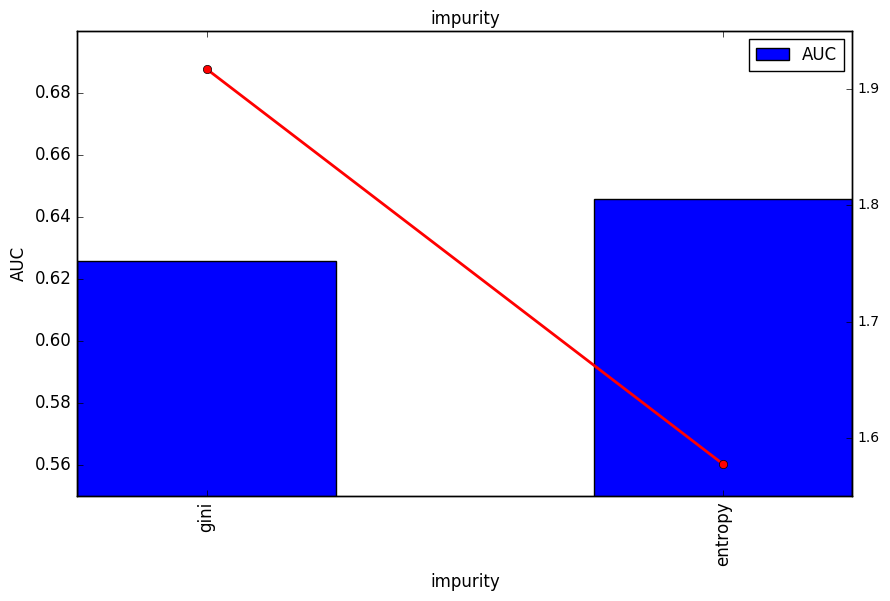

In [58]:
import matplotlib.pyplot as plt
%matplotlib inline 
evalparm='impurity'
ax = df['AUC'].plot(kind='bar', title =evalparm,figsize=(10,6),
                legend=True, fontsize=12)
ax.set_xlabel(evalparm,fontsize=12)
ax.set_ylim([0.55,0.7])
ax.set_ylabel("AUC",fontsize=12)
ax2 = ax.twinx()
ax2.plot(df['duration'].values, linestyle='-', marker='o', linewidth=2.0,color='r')
plt.show()

In [59]:
import matplotlib.pyplot as plt
def showchart(df,evalparm ,barData,lineData,yMin,yMax):
    ax = df[barData].plot(kind='bar', title =evalparm,
                                         figsize=(10,6),legend=True, fontsize=12)
    ax.set_xlabel(evalparm,fontsize=12)
    ax.set_ylim([yMin,yMax])
    ax.set_ylabel(barData,fontsize=12)
    ax2 = ax.twinx()
    ax2.plot(df[lineData ].values, linestyle='-', marker='o',
                    linewidth=2.0,color='r')
    plt.show()

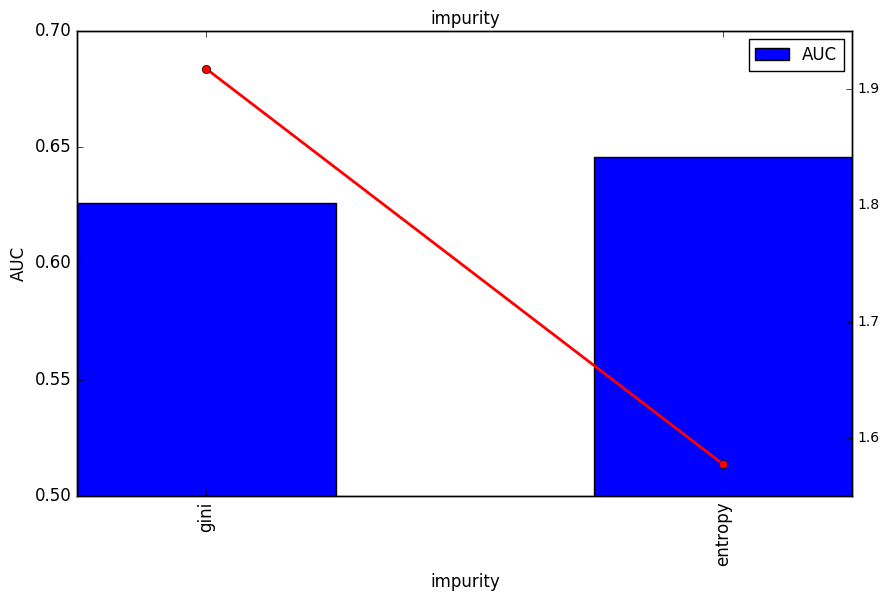

In [60]:
showchart(df,'impurity','AUC','duration',0.5,0.7 )

In [62]:
#定義evalParameter函數
def evalParameter(trainData, validationData, evalparm,
                  impurityList, maxDepthList, maxBinsList):
    #訓練評估參數
    metrics = [trainEvaluateModel(trainData, validationData,  
                                impurity,maxDepth,  maxBins) 
                       for impurity in impurityList
                       for maxDepth in maxDepthList  
                       for maxBins in maxBinsList ]
    #設定目前評估的參數
    if evalparm=="impurity":
        IndexList=impurityList[:]
    elif evalparm=="maxDepth":
        IndexList=maxDepthList[:]
    elif evalparm=="maxBins":
        IndexList=maxBinsList[:]
    #轉換為Pandas DataFrame
    df = pd.DataFrame(metrics,index=IndexList,
            columns=['AUC', 'duration','impurity', 'maxDepth', 'maxBins','model'])
    #顯示圖形
    showchart(df,evalparm,'AUC','duration',0.5,0.7 )

訓練評估：使用參數 impurity=gini maxDepth=10 maxBins=10
 ==>所需時間=1.4680769443511963 結果AUC = 0.6257891414141414
訓練評估：使用參數 impurity=entropy maxDepth=10 maxBins=10
 ==>所需時間=1.3150699138641357 結果AUC = 0.6458333333333333


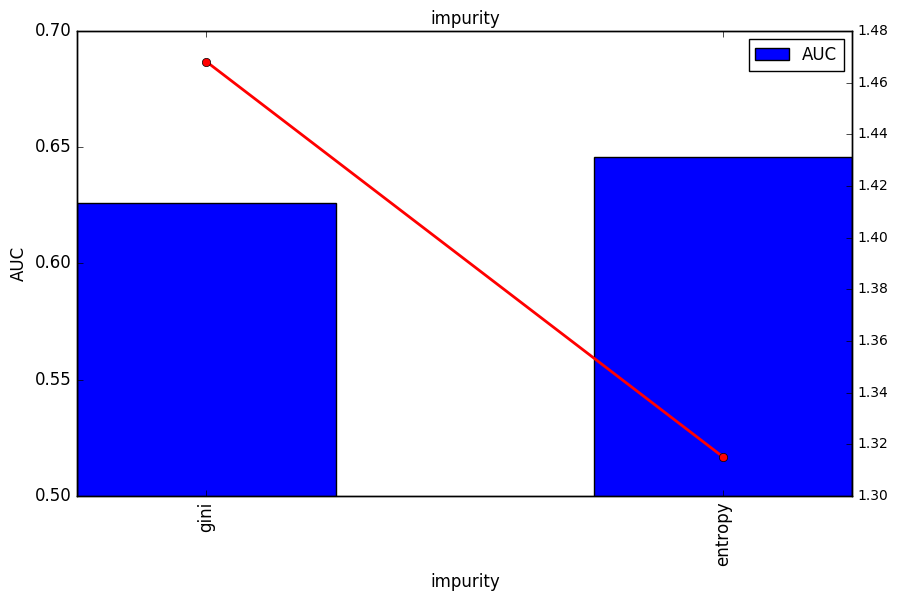

In [63]:
evalParameter(trainData, validationData,"impurity", 
                              impurityList=["gini", "entropy"],   
                              maxDepthList=[10],  
                              maxBinsList=[10 ])

訓練評估：使用參數 impurity=gini maxDepth=3 maxBins=10
 ==>所需時間=0.9188649654388428 結果AUC = 0.5536616161616162
訓練評估：使用參數 impurity=gini maxDepth=5 maxBins=10
 ==>所需時間=0.8034710884094238 結果AUC = 0.6338383838383839
訓練評估：使用參數 impurity=gini maxDepth=10 maxBins=10
 ==>所需時間=1.069148063659668 結果AUC = 0.6257891414141414
訓練評估：使用參數 impurity=gini maxDepth=15 maxBins=10
 ==>所需時間=1.361685037612915 結果AUC = 0.6190025252525253
訓練評估：使用參數 impurity=gini maxDepth=20 maxBins=10
 ==>所需時間=1.5684380531311035 結果AUC = 0.6172664141414141
訓練評估：使用參數 impurity=gini maxDepth=25 maxBins=10
 ==>所需時間=1.8291959762573242 結果AUC = 0.6147411616161617


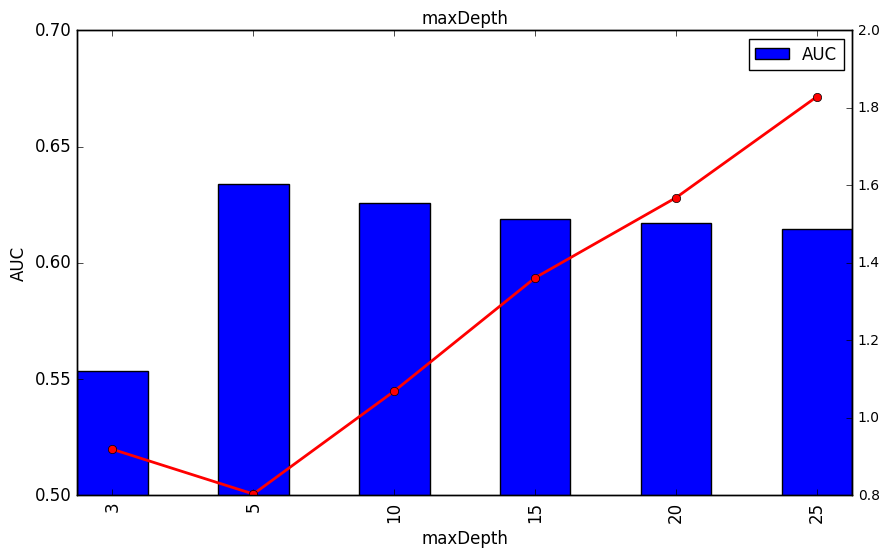

In [64]:
evalParameter(trainData, validationData,"maxDepth", 
                          impurityList=["gini"],                    
                          maxDepthList=[3, 5, 10, 15, 20, 25],    
                          maxBinsList=[10])

訓練評估：使用參數 impurity=gini maxDepth=10 maxBins=3
 ==>所需時間=1.1520678997039795 結果AUC = 0.6286300505050506
訓練評估：使用參數 impurity=gini maxDepth=10 maxBins=5
 ==>所需時間=0.9840021133422852 結果AUC = 0.6532512626262628
訓練評估：使用參數 impurity=gini maxDepth=10 maxBins=10
 ==>所需時間=1.0525970458984375 結果AUC = 0.6257891414141414
訓練評估：使用參數 impurity=gini maxDepth=10 maxBins=50
 ==>所需時間=1.0192580223083496 結果AUC = 0.6671401515151516
訓練評估：使用參數 impurity=gini maxDepth=10 maxBins=100
 ==>所需時間=1.1733958721160889 結果AUC = 0.6658775252525253
訓練評估：使用參數 impurity=gini maxDepth=10 maxBins=200
 ==>所需時間=1.0426840782165527 結果AUC = 0.6789772727272727


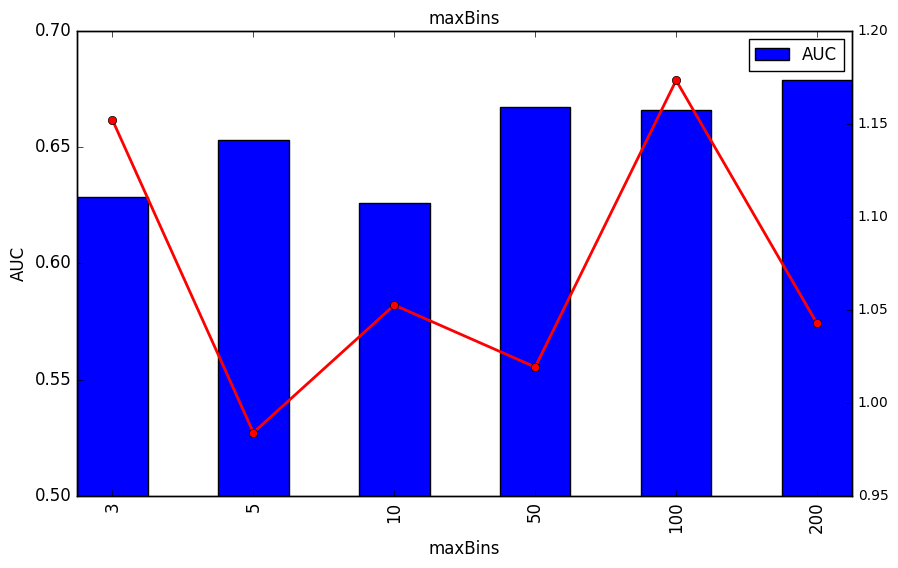

In [68]:
evalParameter(trainData, validationData,"maxBins", 
                          impurityList=["gini"],      
                          maxDepthList =[10],        
                          maxBinsList=[3, 5, 10, 50, 100, 200 ])

In [67]:
6. 找出準確率最高的參數組合

SyntaxError: invalid syntax (<ipython-input-67-7e856d8a3433>, line 1)

In [69]:
#定義evalAllParameter函數
def evalAllParameter(trainData, validationData, 
                     impurityList, maxDepthList, maxBinsList):    
    #for迴圈訓練評估所有參數組合
    metrics = [trainEvaluateModel(trainData, validationData,  
                            impurity,maxDepth,  maxBins  ) 
                      for impurity in impurityList 
                      for maxDepth in maxDepthList  
                      for  maxBins in maxBinsList ]
    #找出AUC最大的參數組合
    Smetrics = sorted(metrics, key=lambda k: k[0], reverse=True)
    bestParameter=Smetrics[0]
    #顯示調校後最佳參數組合      
    print("調校後最佳參數：impurity:" + str(bestParameter[2]) + 
                                      ",maxDepth:" + str(bestParameter[3]) + 
                                     ",maxBins:" + str(bestParameter[4])   + 
                                      "\n,    結果AUC = " + str(bestParameter[0]))
    #傳回最佳模型
    return bestParameter[5]

In [73]:
print("-----所有參數訓練評估找出最好的參數組合---------")  
bestModel=evalAllParameter(trainData, validationData,
                          ["gini", "entropy"],
                          [3, 5, 10, 15], 
                          [5, 10, 50, 100])

-----所有參數訓練評估找出最好的參數組合---------
訓練評估：使用參數 impurity=gini maxDepth=3 maxBins=5
 ==>所需時間=0.6374828815460205 結果AUC = 0.5827020202020202
訓練評估：使用參數 impurity=gini maxDepth=3 maxBins=10
 ==>所需時間=0.5784311294555664 結果AUC = 0.5536616161616162
訓練評估：使用參數 impurity=gini maxDepth=3 maxBins=50
 ==>所需時間=0.5886440277099609 結果AUC = 0.5860164141414141
訓練評估：使用參數 impurity=gini maxDepth=3 maxBins=100
 ==>所需時間=0.5975241661071777 結果AUC = 0.5860164141414141
訓練評估：使用參數 impurity=gini maxDepth=5 maxBins=5
 ==>所需時間=0.7168371677398682 結果AUC = 0.6611426767676768
訓練評估：使用參數 impurity=gini maxDepth=5 maxBins=10
 ==>所需時間=0.7160861492156982 結果AUC = 0.6338383838383839
訓練評估：使用參數 impurity=gini maxDepth=5 maxBins=50
 ==>所需時間=0.630673885345459 結果AUC = 0.6527777777777778
訓練評估：使用參數 impurity=gini maxDepth=5 maxBins=100
 ==>所需時間=0.6587188243865967 結果AUC = 0.6541982323232323
訓練評估：使用參數 impurity=gini maxDepth=10 maxBins=5
 ==>所需時間=0.7862441539764404 結果AUC = 0.6532512626262628
訓練評估：使用參數 impurity=gini maxDepth=10 maxBins=10
 ==>所需時間=0.84

In [72]:
7. 確認是否Overfitting（過度訓練）

SyntaxError: invalid character in identifier (<ipython-input-72-b2c5cc0388bf>, line 1)

In [74]:
AUC=evaluateModel(model, testData)
print ("AUC="+str(AUC))

AUC=0.6362263391059203
